In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
#         tf.config.set_logical_device_configuration(
#             gpus[0],
#             [tf.config.LogicalDeviceConfiguration(memory_limit=10000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

from tensorflow import keras
from tifffile import imsave, imread, imwrite
from keras.models import Input, Model
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler
from tifffile import imwrite

from datagenerator_3D import stack_generator, data_generator
from model_3D_interconnect import make_generator
from loss_3D import generator_loss

1 Physical GPUs, 1 Logical GPUs


In [2]:
frame_start =  8
frame_end =  24
patch_size =  128
n_patches =  8
n_channel =  0
augment = False 
shuffle = True 
batch_size = 1

GT_image_dr = r'C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\20220714\1x ddx39B(646)-gfpson\_7'
lowSNR_image_dr =r'C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\20220714\1x ddx39B(646)-gfpson\_6'


gt,low=stack_generator(GT_image_dr,lowSNR_image_dr, fr_start=frame_start,fr_end=frame_end)

x_train, y_train, x_valid, y_valid = data_generator(gt, low, patch_size, n_patches, n_channel, 
                                                    threshold=50, ratio=1.0,
                                                    fr_start=frame_start, fr_end=frame_end
                                                    ,augment=augment, shuffle=shuffle)

<tifffile.TiffFile '_6_MMStack_Pos1.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_6_MMStack_Pos10.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_6_MMStack_Pos11.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_6_MMStack_Pos12.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_6_MMStack_Pos13.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_6_MMStack_Pos14.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_6_MMStack_Pos15.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_6_MMStack_Pos16.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_6_MMStack_Pos17.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_6_MMStack_Pos18.ome.tif'> OME series is BinaryOnly, not an OME

(21, 32, 2, 512, 512)
(21, 512, 512, 16, 2)
103
The training set shape is: (103, 128, 128, 16, 1)
The validation set shape is: (0, 128, 128, 16, 1)


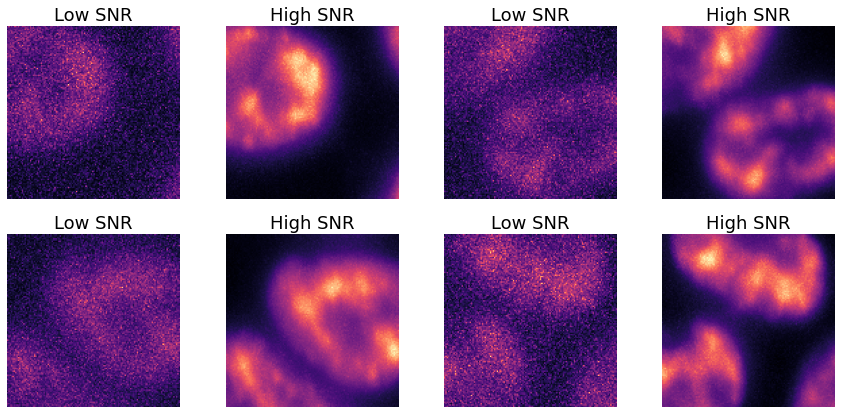

In [3]:
mip_x_train=np.max(x_train,axis=3)
mip_y_train=np.max(y_train,axis=3)

ix = random.sample(range(len(x_train)),4)
fig = plt.figure(figsize=(15,7))

for i in range(4):
    fig.add_subplot(2,4, 2*i+1)
    cmap=plt.get_cmap('magma')
    plt.imshow(mip_x_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('Low SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

    fig.add_subplot(2,4, 2*i+2)
    cmap=plt.get_cmap('magma')
    plt.imshow(mip_y_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('High SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

In [4]:
model_save_directory = r"D:\Models\Data generator\ddx39b-son\ddx39B-file_6.h5" 
load_model_save_directory = r"D:\Models\Data generator\ddx39b-son\ddx39B-file_4.h5" 


n_epochs =  200
gen_lr = 1e-5

filters =[32,64]
num_filters = filters[0]
filters_cab=num_filters/16
num_RG=3
num_RCAB=8

generator_input = Input((patch_size, patch_size,frame_end-frame_start,1))
generator = make_generator(generator_input, filters, num_filters,filters_cab,num_RG,num_RCAB,
                           kernel_shape=3,dropout=0.2)
gen_opt = keras.optimizers.Adam(learning_rate=gen_lr)
generator.compile(optimizer=gen_opt, loss=generator_loss)
generator.load_weights(load_model_save_directory)



def scheduler(epoch, lr):
    if np.mod(epoch+1,20)==0:
        return lr*0.8
    else:
        return lr

callbacks = [
    EarlyStopping(patience=100, verbose=1),
    LearningRateScheduler(scheduler),
    ModelCheckpoint(filepath=model_save_directory, verbose=1, save_best_only=True, save_weights_only=True)]

In [5]:
results = generator.fit(x=x_train,y=y_train, batch_size=batch_size, epochs=n_epochs,verbose=1,
                        callbacks=callbacks,validation_split=0.2)

Epoch 1/200
82/82 [==============================] - ETA: 0s - loss: 0.4860 - conv3d_26_loss: 0.2450 - conv3d_134_loss: 0.2410
Epoch 00001: val_loss improved from inf to 0.42977, saving model to D:\Models\Data generator\ddx39b-son\ddx39B-file_6.h5
82/82 [==============================] - 94s 897ms/step - loss: 0.4860 - conv3d_26_loss: 0.2450 - conv3d_134_loss: 0.2410 - val_loss: 0.4298 - val_conv3d_26_loss: 0.2148 - val_conv3d_134_loss: 0.2150 - lr: 1.0000e-05
Epoch 2/200
82/82 [==============================] - ETA: 0s - loss: 0.2942 - conv3d_26_loss: 0.1491 - conv3d_134_loss: 0.1451
Epoch 00002: val_loss improved from 0.42977 to 0.36967, saving model to D:\Models\Data generator\ddx39b-son\ddx39B-file_6.h5
82/82 [==============================] - 71s 862ms/step - loss: 0.2942 - conv3d_26_loss: 0.1491 - conv3d_134_loss: 0.1451 - val_loss: 0.3697 - val_conv3d_26_loss: 0.1849 - val_conv3d_134_loss: 0.1848 - lr: 1.0000e-05
Epoch 3/200
82/82 [==============================] - ETA: 0s - los

Epoch 20/200
82/82 [==============================] - ETA: 0s - loss: 0.1774 - conv3d_26_loss: 0.0901 - conv3d_134_loss: 0.0873
Epoch 00020: val_loss did not improve from 0.28513
82/82 [==============================] - 72s 873ms/step - loss: 0.1774 - conv3d_26_loss: 0.0901 - conv3d_134_loss: 0.0873 - val_loss: 0.2969 - val_conv3d_26_loss: 0.1477 - val_conv3d_134_loss: 0.1492 - lr: 8.0000e-06
Epoch 21/200
82/82 [==============================] - ETA: 0s - loss: 0.1755 - conv3d_26_loss: 0.0889 - conv3d_134_loss: 0.0866
Epoch 00021: val_loss did not improve from 0.28513
82/82 [==============================] - 71s 871ms/step - loss: 0.1755 - conv3d_26_loss: 0.0889 - conv3d_134_loss: 0.0866 - val_loss: 0.3003 - val_conv3d_26_loss: 0.1479 - val_conv3d_134_loss: 0.1524 - lr: 8.0000e-06
Epoch 22/200
82/82 [==============================] - ETA: 0s - loss: 0.1737 - conv3d_26_loss: 0.0882 - conv3d_134_loss: 0.0855
Epoch 00022: val_loss did not improve from 0.28513
82/82 [======================

Epoch 40/200
82/82 [==============================] - ETA: 0s - loss: 0.1504 - conv3d_26_loss: 0.0763 - conv3d_134_loss: 0.0741
Epoch 00040: val_loss did not improve from 0.26806
82/82 [==============================] - 71s 871ms/step - loss: 0.1504 - conv3d_26_loss: 0.0763 - conv3d_134_loss: 0.0741 - val_loss: 0.2885 - val_conv3d_26_loss: 0.1448 - val_conv3d_134_loss: 0.1436 - lr: 6.4000e-06
Epoch 41/200
82/82 [==============================] - ETA: 0s - loss: 0.1502 - conv3d_26_loss: 0.0762 - conv3d_134_loss: 0.0741
Epoch 00041: val_loss did not improve from 0.26806
82/82 [==============================] - 71s 871ms/step - loss: 0.1502 - conv3d_26_loss: 0.0762 - conv3d_134_loss: 0.0741 - val_loss: 0.2804 - val_conv3d_26_loss: 0.1406 - val_conv3d_134_loss: 0.1398 - lr: 6.4000e-06
Epoch 42/200
82/82 [==============================] - ETA: 0s - loss: 0.1483 - conv3d_26_loss: 0.0753 - conv3d_134_loss: 0.0731
Epoch 00042: val_loss did not improve from 0.26806
82/82 [======================

Epoch 61/200
82/82 [==============================] - ETA: 0s - loss: 0.1356 - conv3d_26_loss: 0.0690 - conv3d_134_loss: 0.0666
Epoch 00061: val_loss improved from 0.26693 to 0.26212, saving model to D:\Models\Data generator\ddx39b-son\ddx39B-file_6.h5
82/82 [==============================] - 72s 873ms/step - loss: 0.1356 - conv3d_26_loss: 0.0690 - conv3d_134_loss: 0.0666 - val_loss: 0.2621 - val_conv3d_26_loss: 0.1327 - val_conv3d_134_loss: 0.1294 - lr: 5.1200e-06
Epoch 62/200
82/82 [==============================] - ETA: 0s - loss: 0.1349 - conv3d_26_loss: 0.0686 - conv3d_134_loss: 0.0663
Epoch 00062: val_loss did not improve from 0.26212
82/82 [==============================] - 71s 872ms/step - loss: 0.1349 - conv3d_26_loss: 0.0686 - conv3d_134_loss: 0.0663 - val_loss: 0.2806 - val_conv3d_26_loss: 0.1422 - val_conv3d_134_loss: 0.1384 - lr: 5.1200e-06
Epoch 63/200
82/82 [==============================] - ETA: 0s - loss: 0.1346 - conv3d_26_loss: 0.0684 - conv3d_134_loss: 0.0662
Epoch 

Epoch 82/200
82/82 [==============================] - ETA: 0s - loss: 0.1254 - conv3d_26_loss: 0.0638 - conv3d_134_loss: 0.0616
Epoch 00082: val_loss did not improve from 0.26212
82/82 [==============================] - 72s 873ms/step - loss: 0.1254 - conv3d_26_loss: 0.0638 - conv3d_134_loss: 0.0616 - val_loss: 0.2693 - val_conv3d_26_loss: 0.1359 - val_conv3d_134_loss: 0.1334 - lr: 4.0960e-06
Epoch 83/200
82/82 [==============================] - ETA: 0s - loss: 0.1252 - conv3d_26_loss: 0.0638 - conv3d_134_loss: 0.0613
Epoch 00083: val_loss improved from 0.26212 to 0.25937, saving model to D:\Models\Data generator\ddx39b-son\ddx39B-file_6.h5
82/82 [==============================] - 72s 876ms/step - loss: 0.1252 - conv3d_26_loss: 0.0638 - conv3d_134_loss: 0.0613 - val_loss: 0.2594 - val_conv3d_26_loss: 0.1315 - val_conv3d_134_loss: 0.1278 - lr: 4.0960e-06
Epoch 84/200
82/82 [==============================] - ETA: 0s - loss: 0.1246 - conv3d_26_loss: 0.0632 - conv3d_134_loss: 0.0614
Epoch 

82/82 [==============================] - ETA: 0s - loss: 0.1196 - conv3d_26_loss: 0.0610 - conv3d_134_loss: 0.0585
Epoch 00102: val_loss did not improve from 0.25925
82/82 [==============================] - 71s 871ms/step - loss: 0.1196 - conv3d_26_loss: 0.0610 - conv3d_134_loss: 0.0585 - val_loss: 0.2700 - val_conv3d_26_loss: 0.1366 - val_conv3d_134_loss: 0.1333 - lr: 3.2768e-06
Epoch 103/200
82/82 [==============================] - ETA: 0s - loss: 0.1187 - conv3d_26_loss: 0.0606 - conv3d_134_loss: 0.0581
Epoch 00103: val_loss did not improve from 0.25925
82/82 [==============================] - 71s 871ms/step - loss: 0.1187 - conv3d_26_loss: 0.0606 - conv3d_134_loss: 0.0581 - val_loss: 0.2634 - val_conv3d_26_loss: 0.1332 - val_conv3d_134_loss: 0.1301 - lr: 3.2768e-06
Epoch 104/200
82/82 [==============================] - ETA: 0s - loss: 0.1182 - conv3d_26_loss: 0.0604 - conv3d_134_loss: 0.0578
Epoch 00104: val_loss did not improve from 0.25925
82/82 [==============================] -

82/82 [==============================] - ETA: 0s - loss: 0.1144 - conv3d_26_loss: 0.0585 - conv3d_134_loss: 0.0559
Epoch 00122: val_loss did not improve from 0.25424
82/82 [==============================] - 71s 870ms/step - loss: 0.1144 - conv3d_26_loss: 0.0585 - conv3d_134_loss: 0.0559 - val_loss: 0.2631 - val_conv3d_26_loss: 0.1333 - val_conv3d_134_loss: 0.1298 - lr: 2.6214e-06
Epoch 123/200
82/82 [==============================] - ETA: 0s - loss: 0.1138 - conv3d_26_loss: 0.0581 - conv3d_134_loss: 0.0557
Epoch 00123: val_loss did not improve from 0.25424
82/82 [==============================] - 71s 871ms/step - loss: 0.1138 - conv3d_26_loss: 0.0581 - conv3d_134_loss: 0.0557 - val_loss: 0.2672 - val_conv3d_26_loss: 0.1352 - val_conv3d_134_loss: 0.1319 - lr: 2.6214e-06
Epoch 124/200
82/82 [==============================] - ETA: 0s - loss: 0.1138 - conv3d_26_loss: 0.0581 - conv3d_134_loss: 0.0557
Epoch 00124: val_loss did not improve from 0.25424
82/82 [==============================] -

Epoch 143/200
82/82 [==============================] - ETA: 0s - loss: 0.1105 - conv3d_26_loss: 0.0565 - conv3d_134_loss: 0.0540
Epoch 00143: val_loss did not improve from 0.25424
82/82 [==============================] - 72s 873ms/step - loss: 0.1105 - conv3d_26_loss: 0.0565 - conv3d_134_loss: 0.0540 - val_loss: 0.2665 - val_conv3d_26_loss: 0.1347 - val_conv3d_134_loss: 0.1318 - lr: 2.0972e-06
Epoch 144/200
82/82 [==============================] - ETA: 0s - loss: 0.1104 - conv3d_26_loss: 0.0565 - conv3d_134_loss: 0.0540
Epoch 00144: val_loss did not improve from 0.25424
82/82 [==============================] - 71s 872ms/step - loss: 0.1104 - conv3d_26_loss: 0.0565 - conv3d_134_loss: 0.0540 - val_loss: 0.2651 - val_conv3d_26_loss: 0.1338 - val_conv3d_134_loss: 0.1313 - lr: 2.0972e-06
Epoch 145/200
82/82 [==============================] - ETA: 0s - loss: 0.1105 - conv3d_26_loss: 0.0566 - conv3d_134_loss: 0.0538
Epoch 00145: val_loss did not improve from 0.25424
82/82 [===================

KeyboardInterrupt: 